# Parameters

In [1]:
#PARAMETERS

# model
Nep = 50
Nbatch = 2048

# bootstrap
APPLY_BOOTS = False
TRAIN_NN = False
NPULLS = 200
SAMPLE_SIZE=500_000 # reduce size of evaluation data

In [2]:
# Variables: Label
# drop out all events with Energies outside the range
LOWER_LIMIT = 100
UPPER_LIMIT = 10**5#10**5

# Variables: NN
NUM_BINS = 10#10 # number of bins (energy classes), output_shape

# Imports and setting seed for PRNG

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
# data management
import os
import pandas as pd

# data processing
import tensorflow as tf
from sklearn import utils
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data

In [5]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)

In [6]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

In [7]:
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

# Discretize the target Neutrino Energy

In [8]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<UPPER_LIMIT) & (df['MCPrimary.energy']>LOWER_LIMIT)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [9]:
df['MCPrimary.energy'].describe()

count    1.326209e+07
mean     2.175633e+03
std      6.605192e+03
min      1.000001e+02
25%      2.696399e+02
50%      5.425823e+02
75%      1.386841e+03
max      9.999541e+04
Name: MCPrimary.energy, dtype: float64

In [10]:
## log-scaled Binning
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [11]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [12]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [13]:
y = df['E_discr'].to_numpy()
y.shape

(13262094,)

In [14]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3, rng_seed=42):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    rng = np.random.default_rng(rng_seed)
    perm = rng.permutation(len(X))
    
    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

NameError: name 'history' is not defined

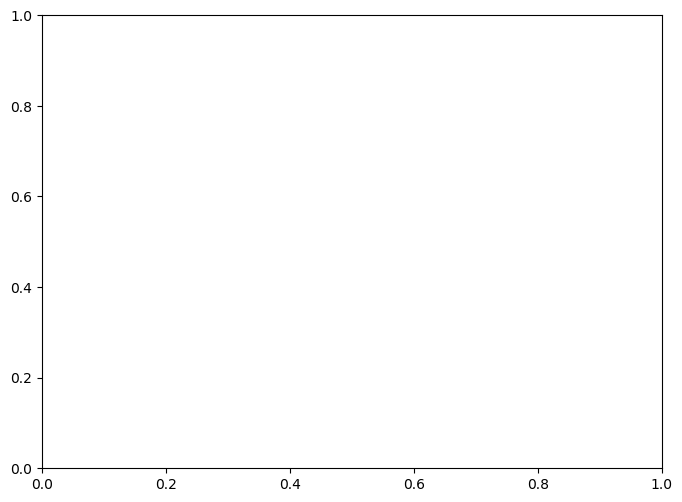

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(history.history['categorical_accuracy'], label='Training', linewidth=3)
ax.plot(history.history['val_categorical_accuracy'], label='Evaluation', linewidth=3)

ax.set_ylabel('Accuracy', fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_xlabel('Epochenzahl', fontsize=15)
ax.set_xticks(np.arange(0,Nep+1,5))
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/acc_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)

In [16]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=None)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 12) (11935884,) (1326210, 12) (1326210,)


In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

In [18]:
# reduce size of test set
y_eval = y_eval[0:SAMPLE_SIZE]
X_eval = X_eval[0:SAMPLE_SIZE]
X_eval.shape, y_eval.shape

((500000, 12), (500000,))

In [19]:
# need one hot encoded vector for softmax
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

y_eval_hot = np.zeros((y_eval.size, y_eval.max()+1))
y_eval_hot[np.arange(y_eval.size),y_eval] = 1

# Build Neural Network

In [20]:
# define metric: chi-square distance
def chi2(y_true, y_pred):
    f_true = tf.reduce_sum(y_true, 0)/2048
    f_pred = tf.reduce_sum(y_pred, 0)/2048

    num = tf.square(f_true - f_pred)
    den = f_true + f_pred
    return 0.5 * tf.reduce_sum(num/den, axis=-1)

In [21]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[acc, chi2])

    return model

# Train the NN or load in weights

In [22]:
model = make_model((len(feature_list),), NUM_BINS, learning_rate=0.0005)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               1560      
_________________________________________________________________
dense_1 (Dense)              (None, 240)               29040     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1452      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                130       
Total params: 61,102
Trainable params: 61,102
Non-trainable params: 0
_________________________________________________________________


In [24]:
if TRAIN_NN:
    history = model.fit(X_train, y_train_hot, batch_size=Nbatch, epochs=Nep, validation_data=(X_eval, y_eval_hot))
    model.save_weights(f'models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
    print(f'Saved model weights to /models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
else:
    model.load_weights(f'models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
    print(f'Load in model weights from /models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')

Load in model weights from /models/10bins_50ep_2048batches.h5


# Trainings history

In [25]:
history.history.keys()

NameError: name 'history' is not defined

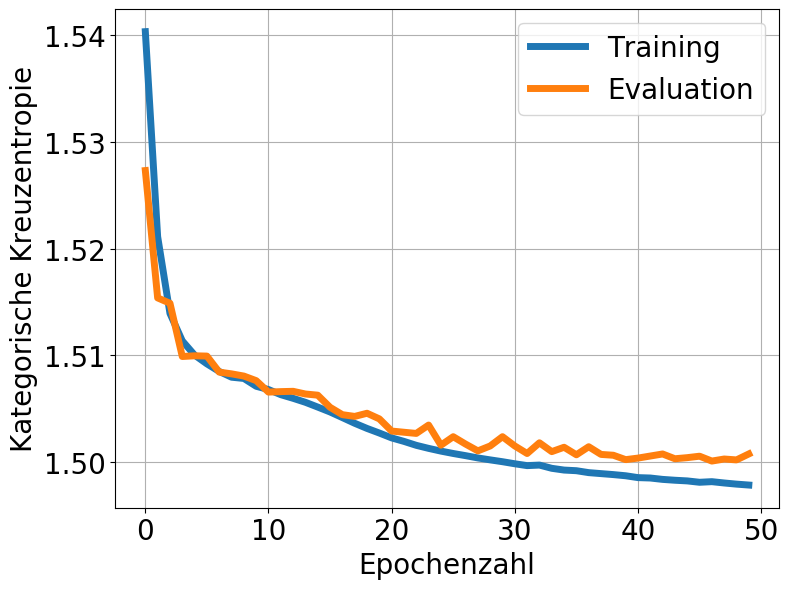

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(np.arange(Nep), history.history['loss'], label='Training', linewidth=5)
ax.plot(np.arange(Nep), history.history['val_loss'], label='Evaluation', linewidth=5)

ax.set_ylabel('Kategorische Kreuzentropie', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)

plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/loss_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)

plt.show()

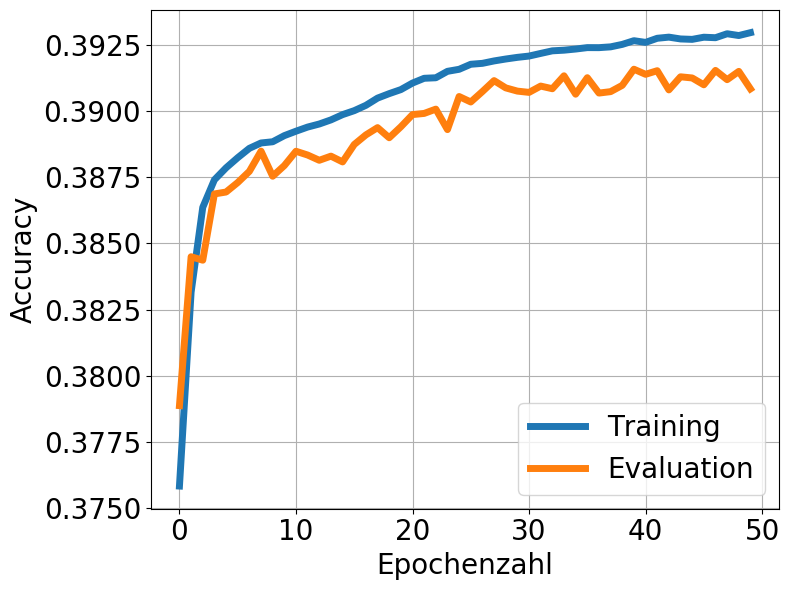

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(history.history['categorical_accuracy'], label='Training', linewidth=5)
ax.plot(history.history['val_categorical_accuracy'], label='Evaluation', linewidth=5)

ax.set_ylabel('Accuracy', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/acc_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)

plt.show()

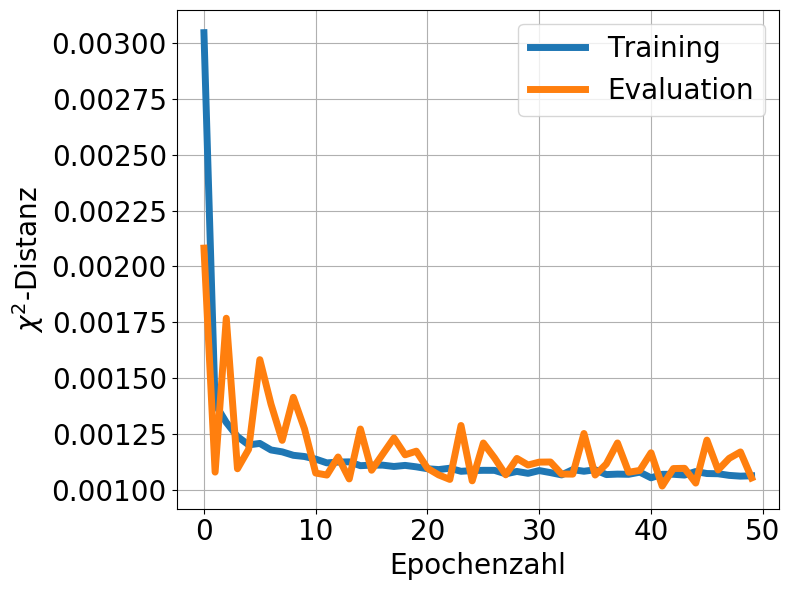

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(history.history['chi2'], label='Training', linewidth=5)
ax.plot(history.history['val_chi2'], label='Evaluation', linewidth=5)

ax.set_ylabel(r'$\chi^2$-Distanz', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/chi_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)


plt.show()

# Evaluation with Bootstrap

In [30]:
if not APPLY_BOOTS:
    df_bootstrap = pd.read_csv(f'bootstrap_results/{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv')
    bootstrap_dsea = df_bootstrap.to_numpy()
    print('Read in bootstrap results.')
else:
    bootstrap_dsea = np.ndarray(shape=(NPULLS,NUM_BINS),dtype=float)
    for i in range(NPULLS):
        if (i+1)%10 ==0:
            print(i+1,' of ', NPULLS)

        # create random subsample of the evaluation data
        X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=SAMPLE_SIZE, random_state=i)# bootstrap random sample from X_test

        # predict subsample
        y_pred_temp = model.predict(X_eval_bst)

        # save f_pred for each evaluation subsample
        bootstrap_dsea[i,:] = y_pred_temp.sum(axis=0)
    
    df_boots = pd.DataFrame(bootstrap_dsea)
    df_boots.to_csv(f'bootstrap_results/{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv', index=False)
    print(f'Bootstrap results saved: /bootstrap_results/{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv')

Read in bootstrap results.


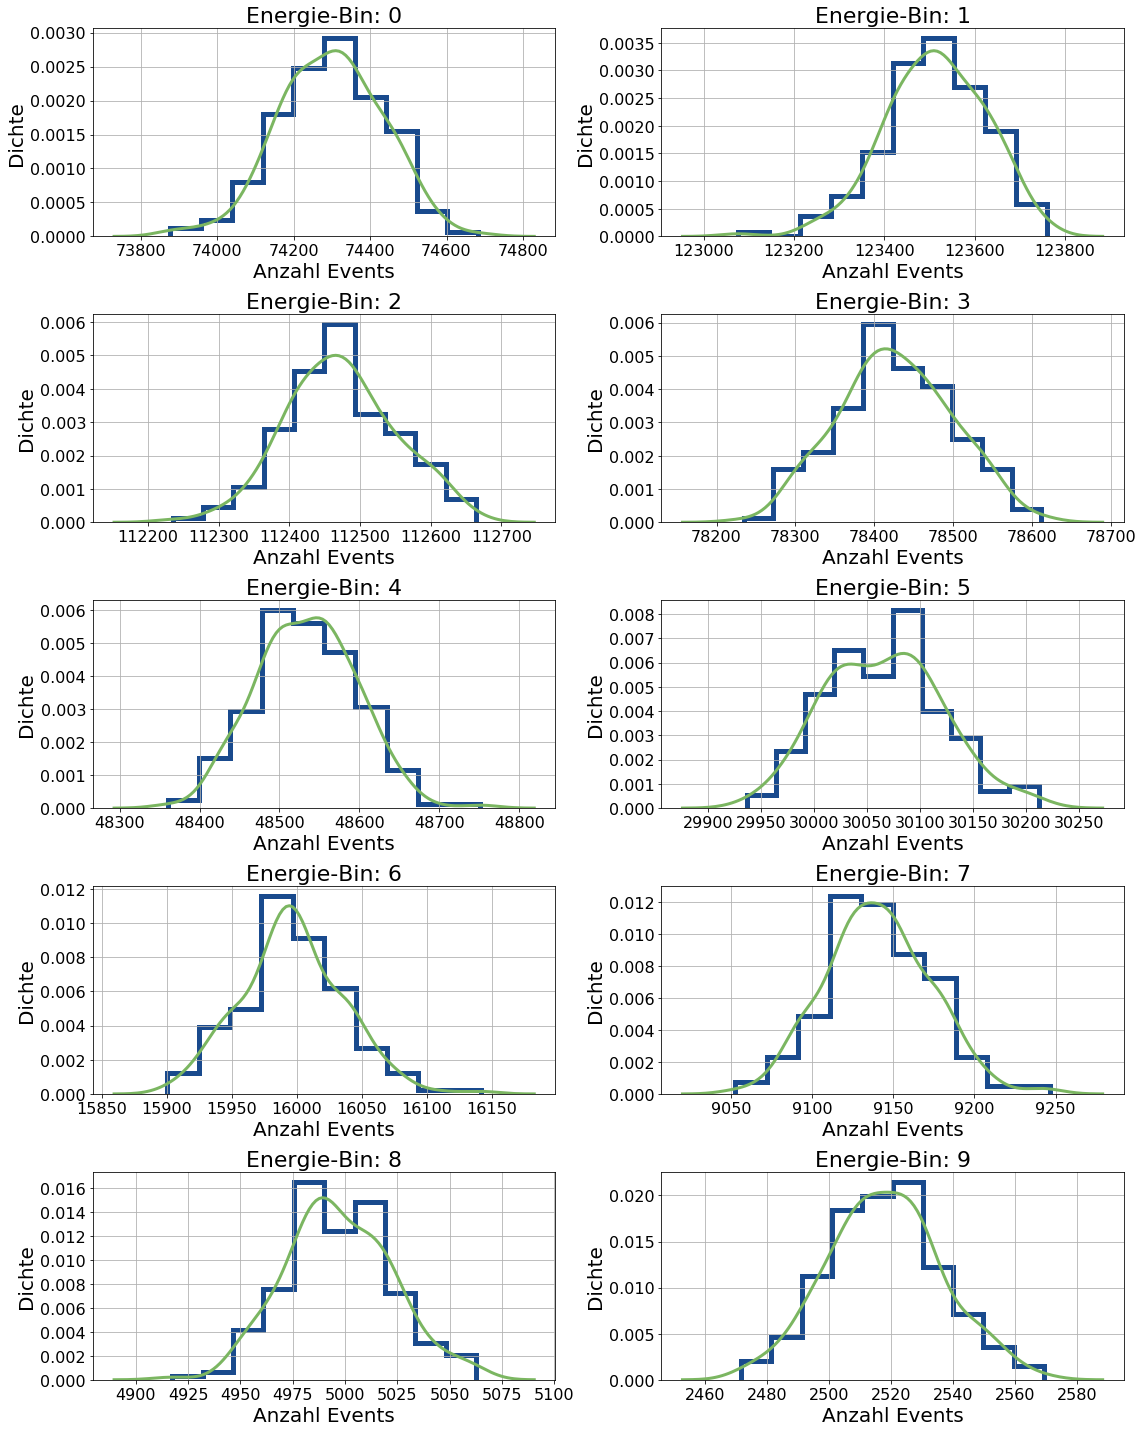

In [41]:
fig, axs = plt.subplots(5,2, figsize=(16,20))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True, kde_kws={'linewidth': 3, 'color': '#7bb661'}, hist_kws={'color': '#194a8d', 'histtype': 'step', 'linewidth': 5, 'alpha': 1})
        axs[i,j].set_xlabel('Anzahl Events', fontsize=20)#df1c44
        axs[i,j].set_ylabel('Dichte', fontsize=20)
        axs[i,j].set_title(f'Energie-Bin: {2*i+j}', fontsize=22)
        plt.setp(axs[i,j].get_xticklabels(), fontsize=16)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=16)
        axs[i,j].grid()

plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/class_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)
plt.show()

In [43]:
boots_mean = bootstrap_dsea.mean(axis=0)
boots_mean_norm = boots_mean/boots_mean.sum()
boots_mean_norm

array([0.14860591, 0.24704541, 0.2249624 , 0.1568655 , 0.09707548,
       0.06013574, 0.03199575, 0.01828267, 0.00999474, 0.00503641])

In [44]:
boots_std = bootstrap_dsea.std(axis=0)
boots_std_norm = boots_std/boots_mean.sum()
boots_std_norm

array([2.69932546e-04, 2.23379966e-04, 1.55509888e-04, 1.42606000e-04,
       1.23222077e-04, 1.09528260e-04, 7.88456271e-05, 6.47906231e-05,
       5.09190526e-05, 3.67394096e-05])

In [45]:
boots_median = np.median(bootstrap_dsea, axis=0)
boots_median_norm = boots_median/boots_median.sum()
boots_median_norm

array([0.14861794, 0.24705306, 0.22495804, 0.15685689, 0.09707972,
       0.06013676, 0.03199111, 0.01828121, 0.00998964, 0.00503563])

In [46]:
quantile_16 = np.quantile(bootstrap_dsea, 0.16, axis=0)
quantile_16_norm = quantile_16/boots_median.sum()
quantile_16_norm

array([0.14835006, 0.24683494, 0.22481486, 0.15671858, 0.09695659,
       0.0600241 , 0.0319101 , 0.01822341, 0.0099476 , 0.00500097])

In [47]:
quantile_84 = np.quantile(bootstrap_dsea, 0.84, axis=0)
quantile_84_norm = quantile_84/boots_median.sum()
quantile_84_norm

array([0.14888527, 0.24726967, 0.22512   , 0.15700978, 0.09719974,
       0.0602387 , 0.03207601, 0.01834988, 0.01004582, 0.00506874])

In [48]:
boots_mean/boots_median

array([0.99990852, 0.99995851, 1.00000888, 1.00004441, 0.99994579,
       0.99997248, 1.00013473, 1.00006884, 1.00049966, 1.00014415])

# True distribution

In [49]:
_, f_true = np.unique(y_eval, return_counts=True)
f_true = f_true/len(y_eval)
f_true

array([0.146518, 0.24642 , 0.223364, 0.159558, 0.099718, 0.05844 ,
       0.032956, 0.018036, 0.009848, 0.005142])

# Predicted distribution: choose max. pred. class

In [50]:
y_pred = model.predict(X_eval)

In [51]:
# choose class with max value
y_pred_max = np.zeros_like(y_pred)
y_pred_max[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
f_max = y_pred_max.sum(axis=0)/len(y_pred_max)
f_max

array([0.166782, 0.379832, 0.255402, 0.099938, 0.041586, 0.031656,
       0.011646, 0.00837 , 0.003716, 0.001072])

# Visualization of the spectrum

In [52]:
f_dsea = boots_median_norm

In [53]:
f_err = np.stack([f_dsea-quantile_16_norm, quantile_84_norm-f_dsea])
f_err

array([[2.67876104e-04, 2.18123819e-04, 1.43183026e-04, 1.38308023e-04,
        1.23130477e-04, 1.12660892e-04, 8.10048182e-05, 5.78005805e-05,
        4.20400478e-05, 3.46627632e-05],
       [2.67328569e-04, 2.16611221e-04, 1.61962368e-04, 1.52892718e-04,
        1.20025588e-04, 1.01938167e-04, 8.49039770e-05, 6.86622217e-05,
        5.61815498e-05, 3.31092055e-05]])

In [54]:
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(NUM_BINS)])
bin_width = np.array([bins[i+1]-bins[i] for i in range(NUM_BINS)])

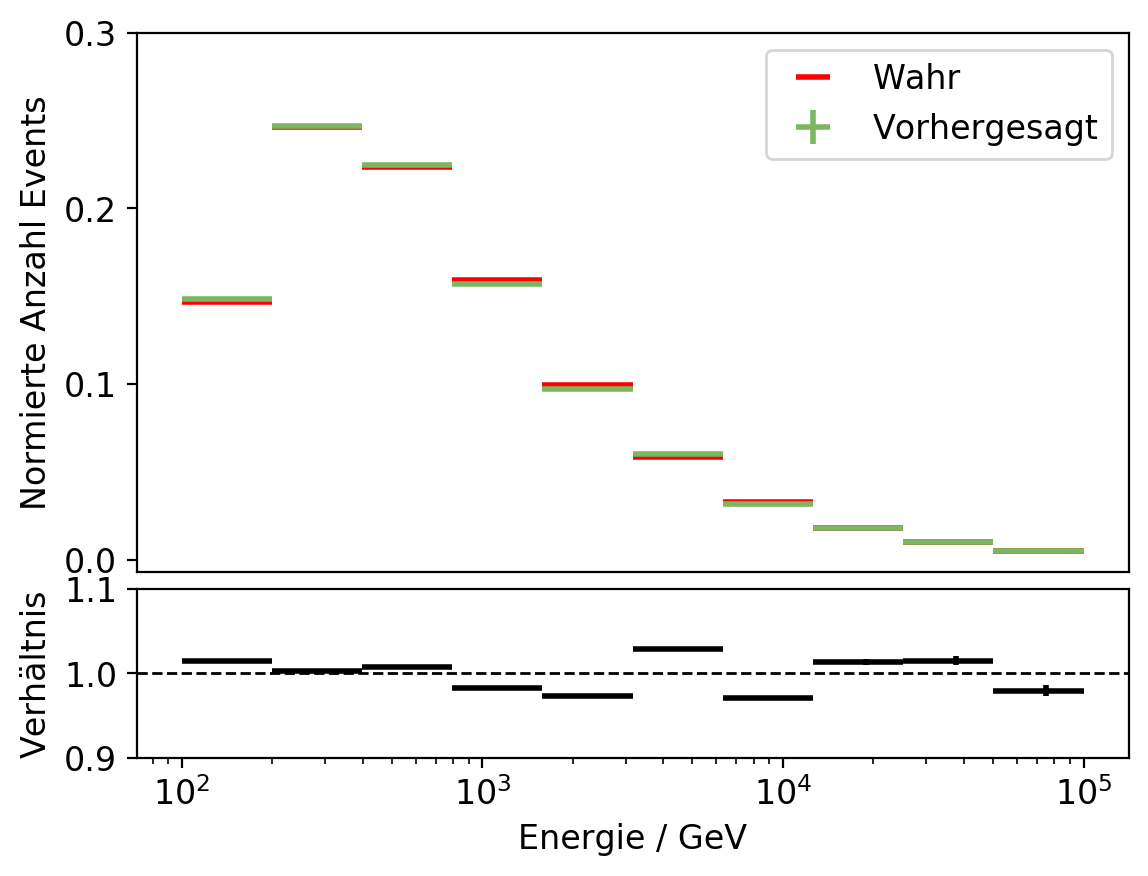

In [55]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_true, fmt=' ', color='red', xerr=bin_width/2, elinewidth=2, label='Wahr') #true distr
axes1.errorbar(bin_centers, f_dsea, fmt=' ', color='#7bb661', xerr=bin_width/2, yerr=f_err, elinewidth=2, label='Vorhergesagt') #pred. distr
axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_yticks([0.0, 0.1, 0.2, 0.3])
axes1.set_ylabel('Normierte Anzahl Events', fontsize=12)
plt.setp(axes1.get_xticklabels(), fontsize=12)
plt.setp(axes1.get_yticklabels(), fontsize=12)

# ratio
axes2.errorbar(bin_centers, f_dsea/f_true, fmt=' ', color='black', xerr=bin_width/2, yerr=f_err/f_true, elinewidth=2)
axes2.axhline(1, color='k', linestyle='--', linewidth=1)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energie / GeV', fontsize=12)
axes2.set_yticks([0.9,1.0,1.1])
axes2.set_ylabel('Verhältnis', fontsize=12)
plt.setp(axes2.get_xticklabels(), fontsize=12)
plt.setp(axes2.get_yticklabels(), fontsize=12)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend(fontsize=12)


plt.savefig(f'bootstrap_results/plots/spectrum_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)
plt.savefig(f'bootstrap_results/plots/spectrum_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.png', dpi=300)


plt.show()

# Spectrum: hard prediction

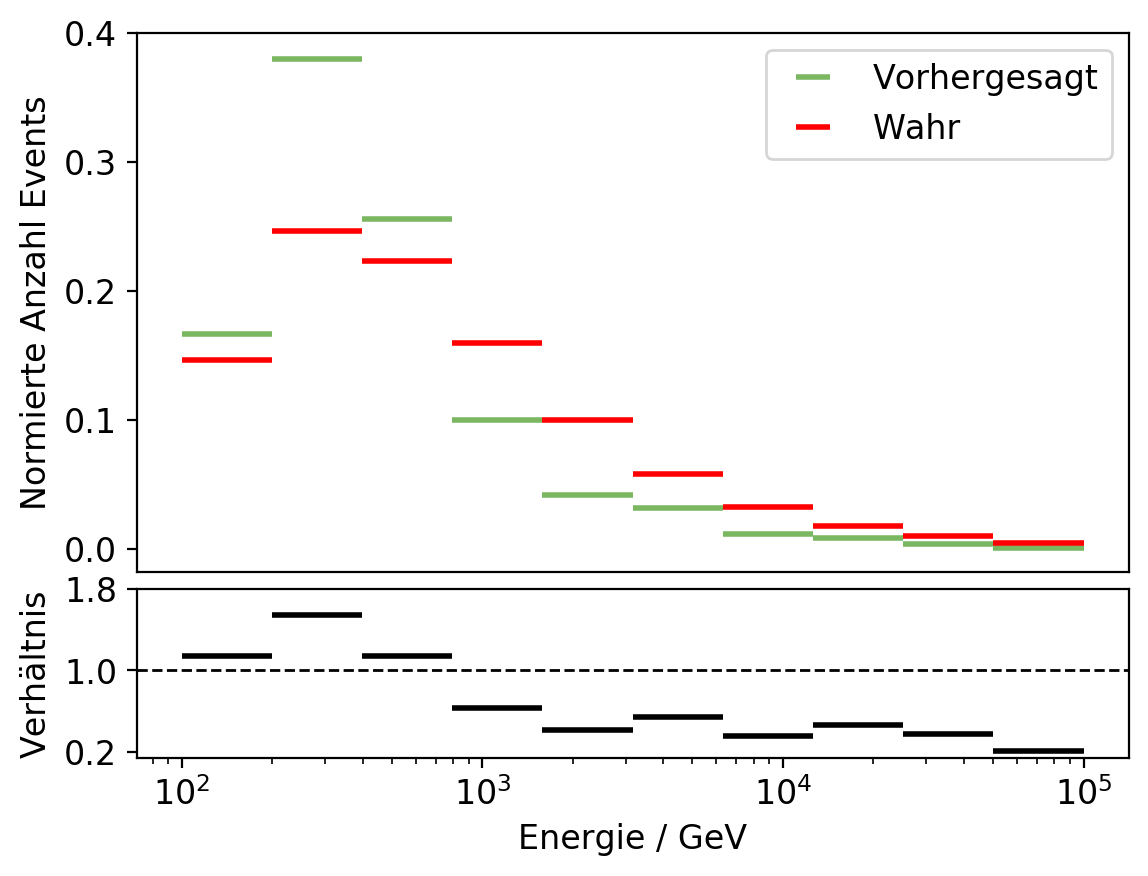

In [56]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_max, fmt=' ', color='#7bb661', xerr=bin_width/2, elinewidth=2, label='Vorhergesagt') #pred. distr
axes1.errorbar(bin_centers, f_true, fmt=' ', color='red', xerr=bin_width/2, elinewidth=2, label='Wahr') #true distr
axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes1.set_ylabel('Normierte Anzahl Events', fontsize=12)
plt.setp(axes1.get_xticklabels(), fontsize=12)
plt.setp(axes1.get_yticklabels(), fontsize=12)

# ratio
axes2.errorbar(bin_centers, f_max/f_true, fmt=' ', color='black', xerr=bin_width/2, elinewidth=2)
axes2.axhline(1, color='k', linestyle='--', linewidth=1)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energie / GeV', fontsize=12)
axes2.set_yticks([0.2,1.0,1.8])
axes2.set_ylabel('Verhältnis', fontsize=12)
plt.setp(axes2.get_xticklabels(), fontsize=12)
plt.setp(axes2.get_yticklabels(), fontsize=12)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend(fontsize=12)

plt.savefig(f'bootstrap_results/plots/spectrum_hard_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)
plt.savefig(f'bootstrap_results/plots/spectrum_hard_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.png', dpi=300)

plt.show()

# Prediction of single events

In [57]:
# index/rows of the single predictions
ind_i = 3594 #245
ind_f = 4600 #251

y_single_pred = y_pred[ind_i:ind_f]
y_single_true = y_eval[ind_i:ind_f]
y_single_pred.shape

(1006, 10)

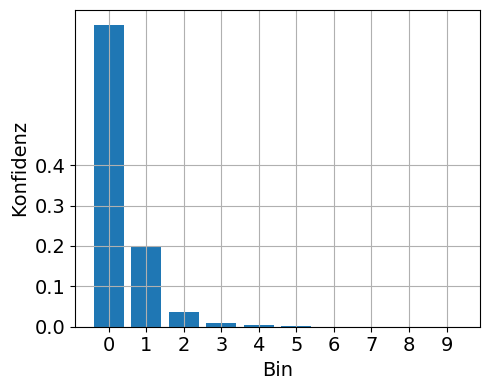

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(5,4), dpi=100)

axs.bar(np.arange(NUM_BINS), y_single_pred[4])     #tucolor: #84b819
#axs.set_title(f'Wahre Klasse: {y_single_true[4]}', fontsize=14)
axs.set_xlabel('Bin', fontsize=14)
axs.set_ylabel('Konfidenz', fontsize=14)
axs.set_xticks(np.arange(NUM_BINS))
axs.set_yticks(np.arange(0,5)*0.1)

plt.setp(axs.get_xticklabels(), fontsize=14)
plt.setp(axs.get_yticklabels(), fontsize=14)

axs.grid()

plt.tight_layout()
plt.savefig('output/single_events1.pdf')
plt.savefig('output/single_events1.png')

plt.show()

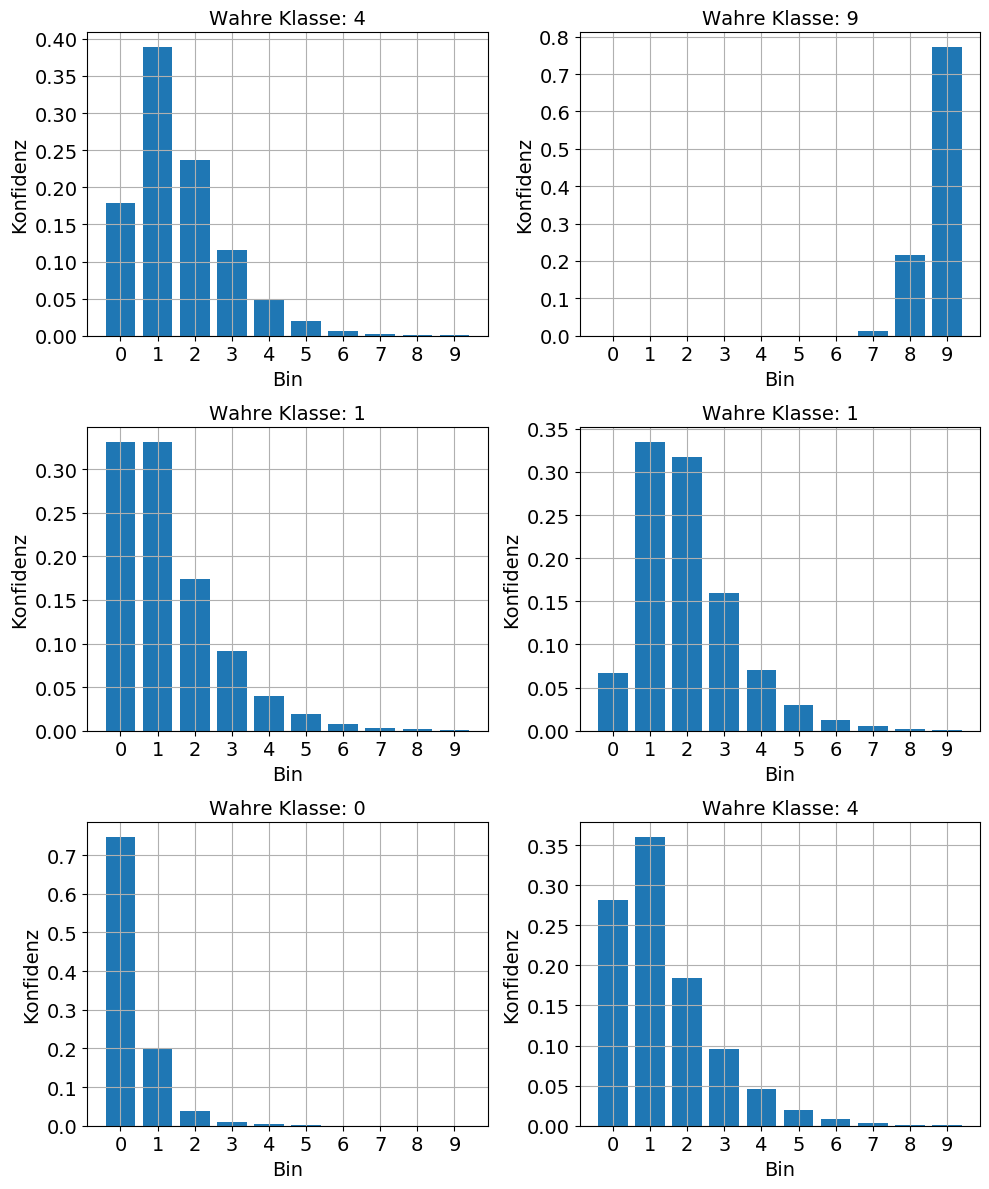

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(10,12), dpi=100)
for i in range(3):
    for j in range(2):
        #axs[i,j].hist(np.arange(NUM_BINS)-bin_width/2, rwidth=bin_width, weights=y_single_pred[i+j], histtype='step')
        axs[i,j].bar(np.arange(NUM_BINS), y_single_pred[2*i+j])
        
        axs[i,j].set_title(f'Wahre Klasse: {y_single_true[2*i+j]}', fontsize=14)
        axs[i,j].set_xlabel('Bin', fontsize=14)
        axs[i,j].set_ylabel('Konfidenz', fontsize=14)
        axs[i,j].set_xticks(np.arange(NUM_BINS))
        axs[i,j].grid()
        plt.setp(axs[i,j].get_xticklabels(), fontsize=14)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.savefig('output/single_events.pdf', dpi=300)
plt.savefig('output/single_events.png', dpi=300)

plt.show()

# Correlation matrix

In [60]:
y_pred_cls = np.argmax(y_pred, axis=1)

In [61]:
df_results = pd.DataFrame(data=y_pred)
matrix = df_results.corr()

In [62]:
mask = np.triu(np.ones_like(matrix, dtype=bool))

In [63]:
# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=15, center="light", as_cmap=True)

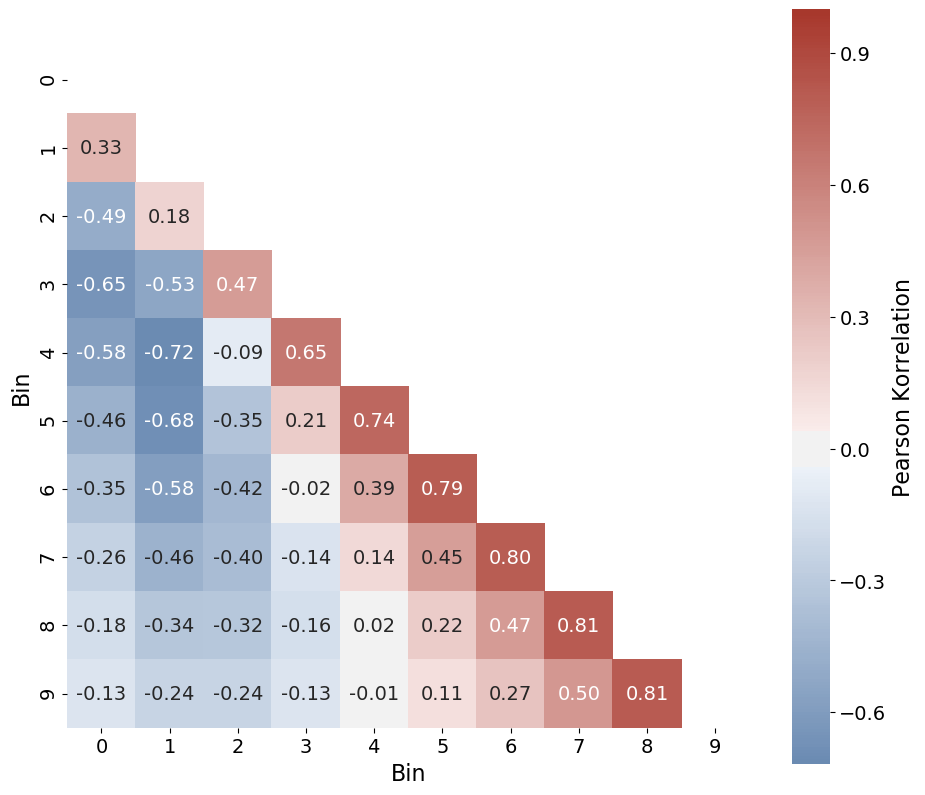

In [64]:

plt.figure(figsize=(11,10), dpi=100)
ax = sns.heatmap(matrix, mask=mask, annot=True, fmt='.2f', center=0, square=True, cmap=cmap, annot_kws={"fontsize":14}) #'coolwarm'

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#plt.title('Correlation matrix')
plt.xlabel('Bin', fontsize=16)
plt.ylabel('Bin', fontsize=16)

#colorbar config
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Pearson Korrelation', fontsize=16)

plt.savefig('output/correlation.pdf')
plt.savefig('output/correlation.png')

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_eval, y_pred_cls)

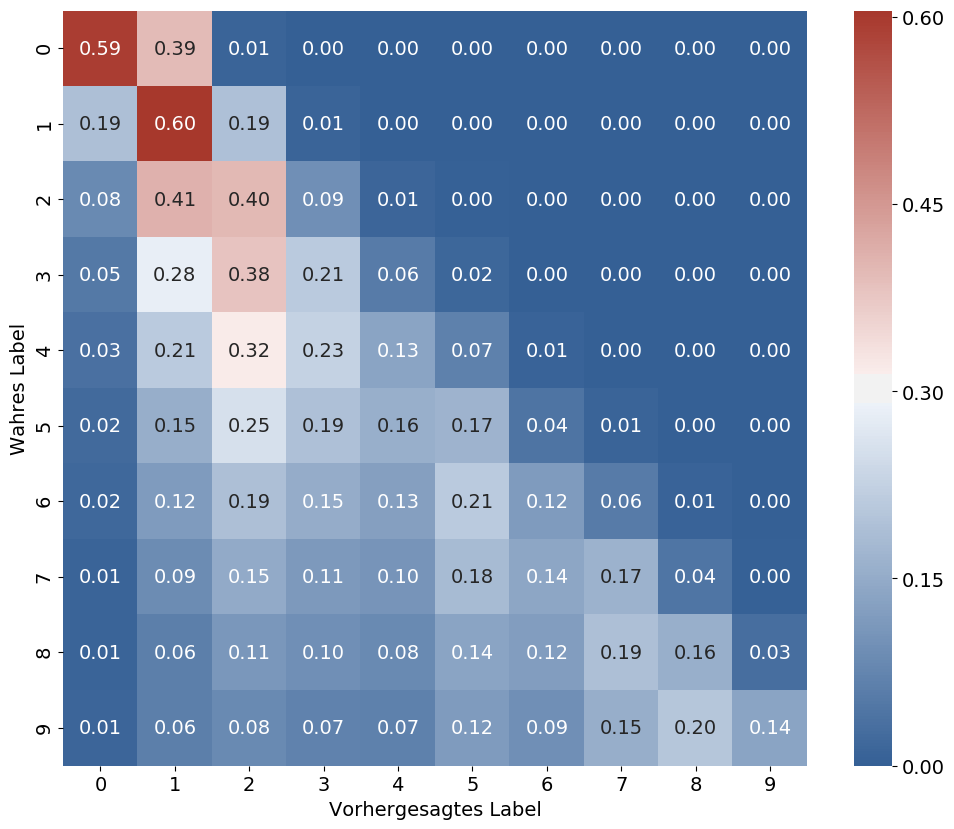

In [ ]:
df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(12,10), dpi=100)
#fix bug in matlotlib 3.1.0/1

ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap, annot_kws={"fontsize":14})
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Vorhergesagtes Label', fontsize=14)
plt.ylabel('Wahres Label', fontsize=14)

#colorbar config
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.savefig('output/confusion_matrix.pdf')
plt.savefig('output/confusion_matrix.png')

plt.show()

# Metrics

In [ ]:
chi2 = 0.5 * np.sum((f_dsea-f_true)**2 / (f_dsea+f_true))
chi2

6.112093154258096e-05

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Evaluation data:\r')
print('Accuracy: %.4f' % accuracy_score(y_eval, y_pred_cls))
print("Precision: %.4f" % precision_score(y_eval, y_pred_cls, average='weighted'))
print("Recall: %.4f" % recall_score(y_eval, y_pred_cls, average='weighted'))
print(classification_report(y_eval, y_pred_cls))

Evaluation on Evaluation data:
Accuracy: 0.3908
Precision: 0.3798
Recall: 0.3908
              precision    recall  f1-score   support

           0       0.52      0.59      0.56     73259
           1       0.39      0.60      0.48    123210
           2       0.35      0.40      0.37    111682
           3       0.34      0.21      0.26     79779
           4       0.32      0.13      0.19     49859
           5       0.31      0.17      0.22     29220
           6       0.34      0.12      0.17     16478
           7       0.36      0.17      0.23      9018
           8       0.42      0.16      0.23      4924
           9       0.65      0.14      0.22      2571

    accuracy                           0.39    500000
   macro avg       0.40      0.27      0.29    500000
weighted avg       0.38      0.39      0.37    500000



In [ ]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_eval, y_pred_cls, average='micro')
print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.2429
